# Visual pollution dataction Model

## Necessary Setup
make sure to restart the runtime after install super-gradients

In [1]:
!pip install super-gradients

## import necessary libraries

In [2]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
from PIL import Image
from tqdm import tqdm

The console stream is logged into /root/sg_logs/console.log


[2023-09-18 15:38:32] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-09-18 15:38:33] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-18 15:38:41] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-18 15:38:44] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-18 15:38:44] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-18 15:38:44] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


## Get the Dataset

The data set was obtained from Roboflow

**the link:** https://universe.roboflow.com/visual-pollution-056la/visual-pollution-pc2as/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true
- we performed data cleaning to remove duplicate images in both training and testing sets.
- Also we made modifications to some of the classes to better align with our project requirements.

In [3]:
# open my drive
from google.colab import drive
drive.mount('/content/drive')

In [4]:
!cd /content/drive/MyDrive

In [19]:
# unzip the dataset
!yes|unzip -q /content/drive/MyDrive/Visual_Pollution.zip -d Visual_Pollution

## set up dataset and global parameters

In [20]:
ROOT_DIR = '/content/Visual_Pollution'
train_imgs_dir = '/content/Visual_Pollution/Visual_Pollution/train/images'
train_labels_dir = '/content/Visual_Pollution/Visual_Pollution/train/labels'
val_imgs_dir = '/content/Visual_Pollution/Visual_Pollution/val/images'
val_labels_dir = '/content/Visual_Pollution/Visual_Pollution/val/labels'
test_imgs_dir = '/content/Visual_Pollution/Visual_Pollution/test/images'
test_labels_dir = '/content/Visual_Pollution/Visual_Pollution/test/labels'
classes = ['jersey barrier gap', 'defective sidewalk', 'defective speedbumps', 'garbage', 'pothole'] # we modify the names of the class to be more meaningful

In [22]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes
}

In [23]:
# Global parameters.
EPOCHS = 200
BATCH_SIZE = 16
WORKERS = 2
CHECKPOINT_DIR = 'checkpoints' # this is the directory where results from all the experiments will be saved

## Visualize samples of the trainig set

In [29]:
# choose randome colors for the bounding boxes
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [25]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [26]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [27]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

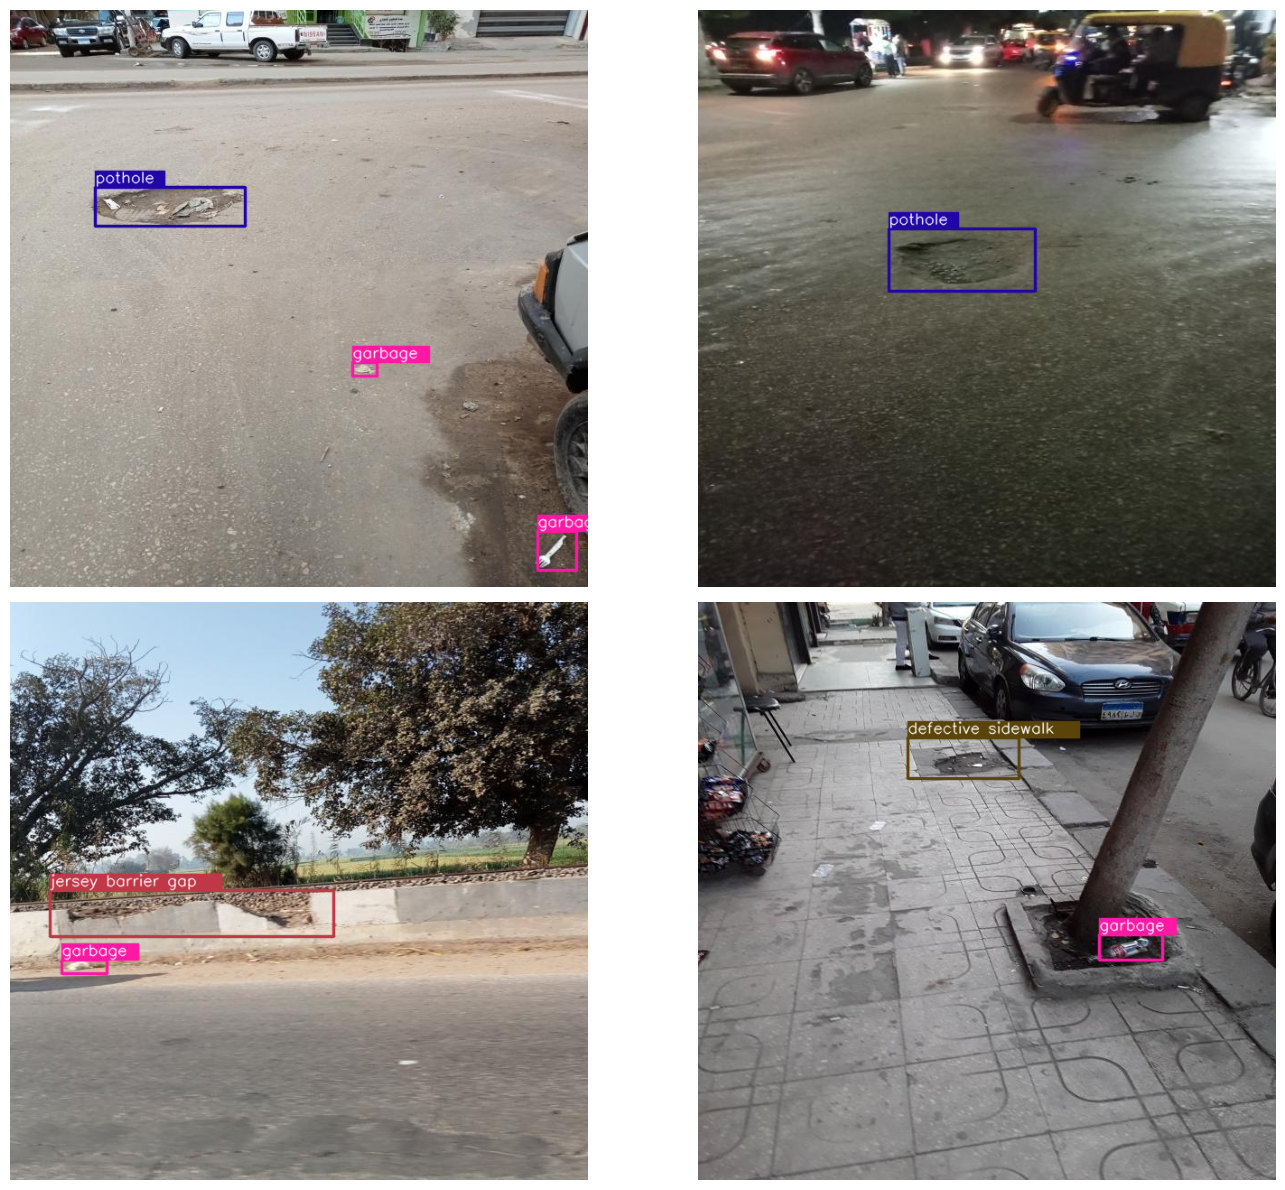

In [45]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4
)

## Data Preparation

In [46]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2023-09-18 16:08:25] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2670/2670 [00:00<00:00, 5239.49it/s]
[2023-09-18 16:08:25] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 330/330 [00:00<00:00, 7218.32it/s]
[2023-09-18 16:08:25] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:   0%|          | 0/330 [00:00<?, ?it/s]

## modify YOLO-NAS Augmentations techniques

After several experiments we find out that removing the DetectionMixup transformer and the DetectionHorizontalFlip transformer will make the model perform better for our project

In [47]:
# display the augmentations techniqes
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [48]:
# remove the DetectionMixup trasformer
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [49]:
# remove the DetectionHorizontalFlip trasformer
train_data.dataset.transforms.pop(3)

DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5)

In [50]:
# display the augmentations techniques again to make sure the two transformers are removed
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name=bboxes length=4 format=<super_gradients.training.datasets.data_formats.bbox_fo

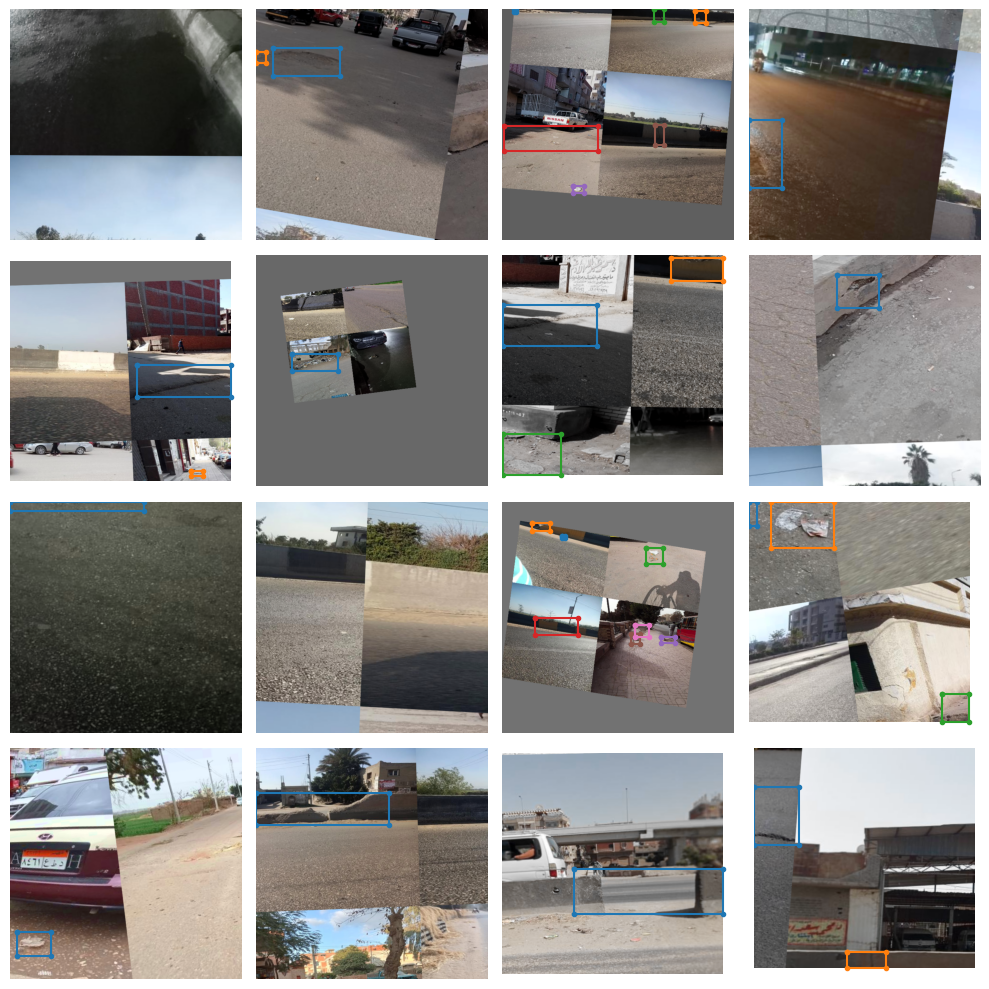

In [52]:
# visualize the images with augmentation
train_data.dataset.plot(plot_transformed_data=True)

## Prepare Model and Training Parameters

In [53]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

### Model Training

In [ ]:
trainer = Trainer(
        experiment_name='yolo_nas_s',
        ckpt_root_dir=CHECKPOINT_DIR
    )

model = models.get(
        'yolo_nas_s',
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data

    )

## Analyze training metrics
run this cell while training and don't forget to refresh it

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $CHECKPOINT_DIR --bind_all

###These are the result from tensorboard for the training and validation:

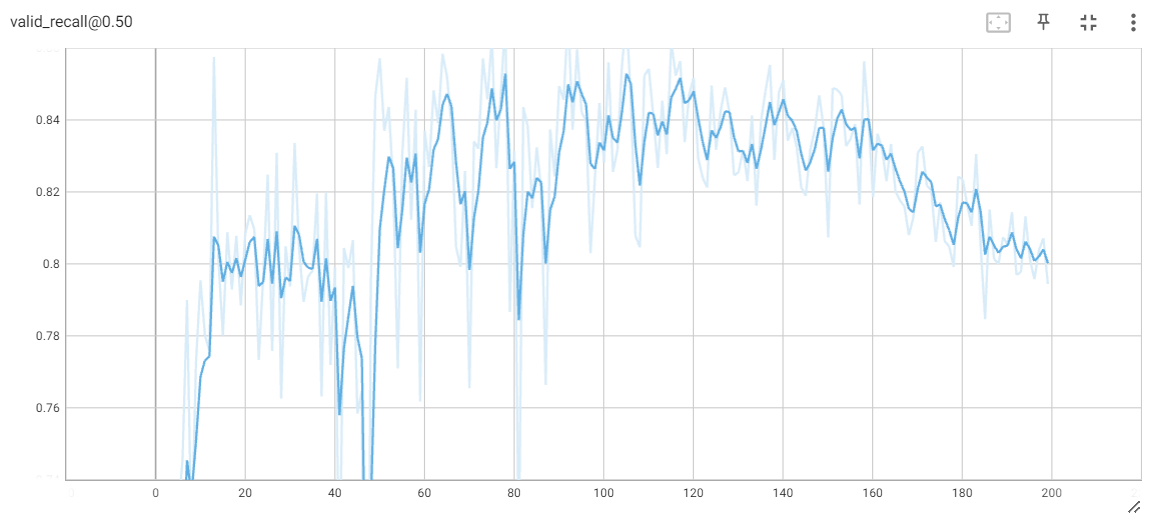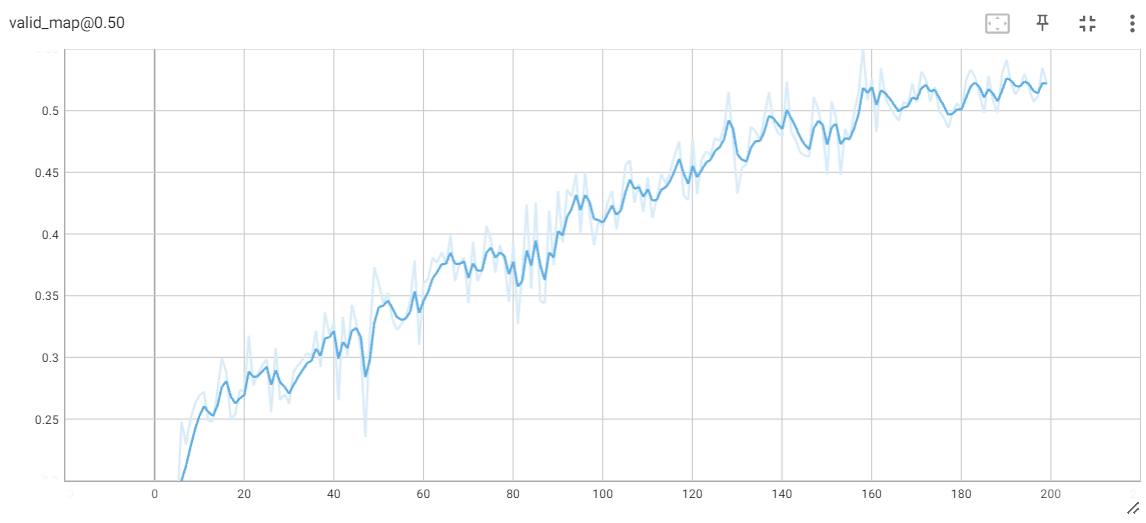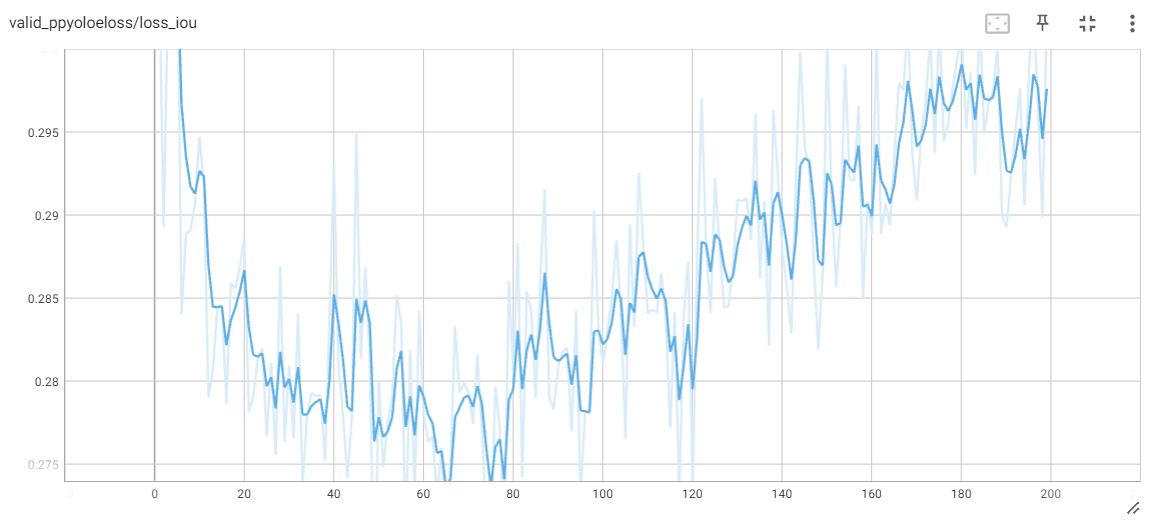

##Test the model

In [15]:
trainer = Trainer(
        experiment_name='Test',
        ckpt_root_dir=CHECKPOINT_DIR
    )

mymodel = models.get(
    model_name='yolo_nas_s',
    checkpoint_path='/content/drive/MyDrive/ckpt_best.pth', # we put our model best checkpoint path here
    num_classes=5
)

trainer.test(
    model=mymodel,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

[2023-09-18 15:45:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/ckpt_best.pth EMA checkpoint.
Testing: 100%|██████████| 18/18 [00:06<00:00,  4.08it/s]

{'Precision@0.50': 0.05353133752942085,
 'Recall@0.50': 0.7866723537445068,
 'mAP@0.50': 0.6579645872116089,
 'F1@0.50': 0.0997551679611206}

**The map is 0.65 which is not bad**

We think the reason that the F1 score and precision are low, even though the prediction of the model is good, is because of the imbalance between the classes in the data set, and unfortunately, we didn't have time or computer power to handle it.


## Inference

In [54]:
# this function make the predection and save in inference_result folder
def predict_and_save_images(input_path):
  model = models.get(
    model_name='yolo_nas_s',
    checkpoint_path='/content/drive/MyDrive/ckpt_best.pth',
    num_classes=5
)
  os.makedirs('inference_results/images/', exist_ok=True)
  ROOT_TEST = input_path
  all_images = os.listdir(ROOT_TEST)
  for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('/content/inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg',
        os.path.join('/content/inference_results/images', image)
    )
  display_images('/content/inference_results/images') # call the display_images function to display the results



In [55]:
# this function display the results
def display_images(output_dir):
    image_files = os.listdir(output_dir)

    for image_file in image_files:
        image_path = os.path.join(output_dir, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.show()

[2023-09-18 16:31:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/ckpt_best.pth EMA checkpoint.
100%|██████████| 3/3 [00:07<00:00,  2.63s/it]


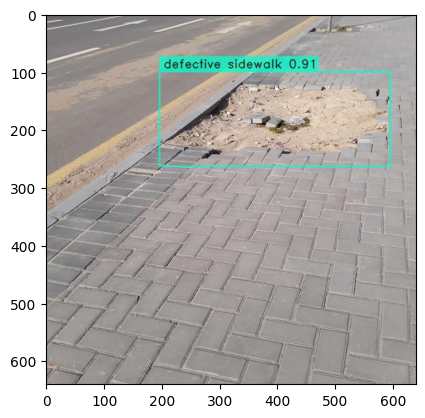

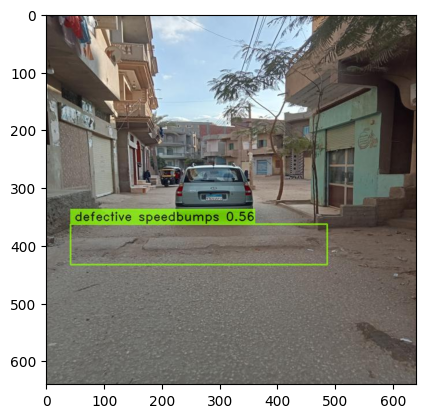

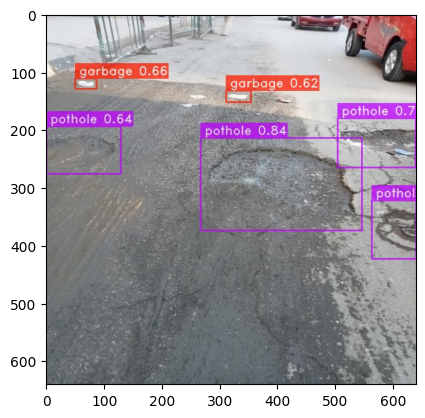

In [56]:
# put inference images folder path
predict_and_save_images('/content/drive/MyDrive/inference')